In [1]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import LSTM

from keras.layers.convolutional import ZeroPadding1D
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import AveragePooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from matplotlib import pyplot
from numpy import array
from numpy import concatenate
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
	
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [3]:
inc = read_csv("../data/H3N2-USA-inc-month.csv", header = 0, index_col = 0)
cov = read_csv("../data/H3N2-USA-cov-month-fitness.csv", header = 0, index_col = 0)
# cov = cov[['pop', 'dpop', 'month1', 'month2', 'month3', 'month4', 'month5',
#        'month6', 'H1N', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9',
#        'y10', 'y11', 'y12', 'y13']]
cov = cov[['month1', 'month2', 'month3', 'month4', 'month5',
       'month6', 'H1N', 'y1', 'y2', 'y3', 'y4', 'y5']]
dataset = pd.concat([cov,inc], axis = 1)
dataset = dataset.iloc[3:,]
dataset.head(4)

,month1,month2,month3,month4,month5,month6,H1N,y1,y2,y3,y4,y5,H3N
month,,,,,,,,,,,,,
2003.000000,0.666667,0.166667,0.000000,0.000000e+00,0.0,0.166667,922174,1.252386,1.647591,1.054771,1.017501,0.810224,221326
2003.083333,0.479167,0.479167,0.020833,0.000000e+00,0.0,0.020833,4044901,1.224892,1.624514,1.087051,1.058360,0.844767,1528254
2003.166667,0.166667,0.666667,0.166667,1.567900e-38,0.0,0.000000,1475084,1.141848,1.493192,1.057678,1.053394,0.846697,590119
2003.250000,0.020833,0.479167,0.479167,2.083333e-02,0.0,0.000000,242687,1.073057,1.408356,1.024995,1.033565,0.843297,266967


## What are we trying to predict

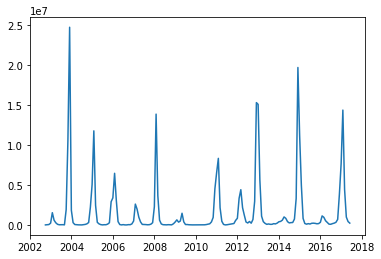

In [4]:
pyplot.plot(inc)

In [12]:
num_month = 12
n_pred = 1
batch_s=12
num_epochs=100
dropout_rate = 0

n_features = len(dataset.columns) - 1

values = dataset.values
# integer encode direction
values = values.astype('float32')
# normalize features

## use previous "num_month" data points (all features)
## to predict the next "n_pred" incidence data

# frame as supervised learning
reframed = series_to_supervised(values, num_month, n_pred)
#reframed.drop(reframed.columns[23:45], axis=1, inplace=True)
#reframed.drop(reframed.columns[(n_features):-n_pred], axis=1, inplace=True)
X = reframed[reframed.columns[:num_month*(n_features+1)]]
y_col = ['var%d(t)' % (n_features+1)] + [('var%d(t+%d)' % (n_features+1, i)) for i in range(1,n_pred)]
y = reframed[y_col]
reframed = pd.concat([X,y], axis = 1)
# ('var%d(t+%d)' % (j+1, i))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)
# specify the number of lag hours


#num_month = 3
num_pred = n_pred

values = dataset.values
# integer encode direction
values = values.astype('float32')
# normalize features

n_month = num_month
n_features = len(dataset.columns) - 1
n_pred = num_pred
# frame as supervised learning
reframed = series_to_supervised(values, n_month, n_pred)
#reframed.drop(reframed.columns[23:45], axis=1, inplace=True)
#reframed.drop(reframed.columns[(n_features):-n_pred], axis=1, inplace=True)
X = reframed[reframed.columns[:n_month*(n_features+1)]]
y_col = ['var%d(t)' % (n_features+1)] + [('var%d(t+%d)' % (n_features+1, i)) for i in range(1,n_pred)]
y = reframed[y_col]
reframed = pd.concat([X,y], axis = 1)
# ('var%d(t+%d)' % (j+1, i))

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)
# specify the number of lag hours

# split into train and test sets
#values = reframed.values
values = scaled

n_train_month = 12*8
train = values[:n_train_month, :]
test = values[n_train_month:, :]

# split into input and outputs
train_X, train_y = train[:, :-num_pred], train[:, -num_pred:]
test_X, test_y = test[:, :-num_pred], test[:, -num_pred:]
# reshape input to be 3D [samples, timesteps, features]

## need to change the shape here !@!@!
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1],1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1],1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(96, 156, 1) (96, 1) (66, 156, 1) (66, 1)


In [14]:
# design network
model = Sequential()
## note differences : here specifying batch_size not here but in "fit"
#model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Conv1D(64, kernel_size=3, padding="same", 
                    input_shape=(train_X.shape[1],1)))
model.add(Conv1D(32, kernel_size=3))
model.add(AveragePooling1D(pool_size=3, strides=1))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1]))
model.compile(loss='mean_absolute_error', optimizer='adam')#SGD(lr=0.001, decay=1e-5))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 156, 64)           256       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 154, 32)           6176      
_________________________________________________________________
average_pooling1d_5 (Average (None, 152, 32)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4864)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4864)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4865      
Total params: 11,297
Trainable params: 11,297
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(train_X, train_y, epochs=num_epochs, batch_size=batch_s, validation_data=(test_X, test_y), verbose=0, shuffle=False)


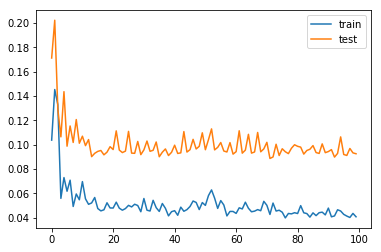

In [16]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [20]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat = concatenate((test_X,yhat), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inverse_transform(inv_yhat)

# inv_yhat = inv_yhat[:,:num_pred]
inv_yhat = inv_yhat[:,-num_pred:]

#inv_yhat = inv_yhat[0,:]

# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = concatenate((test_y, test_X), axis=1)
inv_y = concatenate((test_X,test_y), axis=1)

inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,:num_pred]
inv_y = inv_y[:,-num_pred:]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# #pyplot.plot(inv_y[1,:])
# #pyplot.plot(inv_yhat[1,:])

# for i in range(61):
#     pyplot.plot(inv_y[i,:])
#     pyplot.plot(inv_yhat[i,:])
#     pyplot.show()

# for i in range(num_pred):
#     pyplot.plot(inv_y[:,i])
#     pyplot.plot(inv_yhat[:,i])
#     pyplot.show()

# make a prediction
yhat_t = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))
# invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat_t = concatenate((train_X,yhat_t), axis=1)

inv_yhat_t = scaler.inverse_transform(inv_yhat_t)
#inv_yhat = inverse_transform(inv_yhat)

# inv_yhat = inv_yhat[:,:num_pred]
inv_yhat_t = inv_yhat_t[:,-num_pred:]

#inv_yhat = inv_yhat[0,:]

# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = concatenate((test_y, test_X), axis=1)
inv_y_t = concatenate((train_X,train_y), axis=1)

inv_y_t = scaler.inverse_transform(inv_y_t)
# inv_y = inv_y[:,:num_pred]
inv_y_t = inv_y_t[:,-num_pred:]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_t, inv_yhat_t))
print('Train RMSE: %.3f' % rmse)


Test RMSE: 3842500.580
Train RMSE: 1641482.101


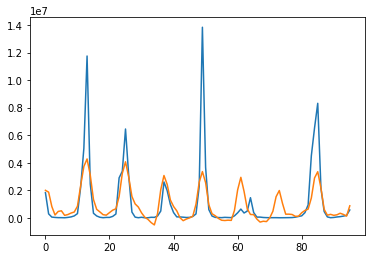

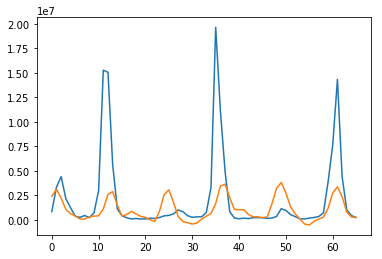

In [21]:
for i in range(n_pred):
    pyplot.plot(inv_y_t[:,i])
    pyplot.plot(inv_yhat_t[:,i])
    pyplot.show()
    
for i in range(num_pred):
    pyplot.plot(inv_y[:,i])
    pyplot.plot(inv_yhat[:,i])
    pyplot.show()